In [1]:
import dp4gp_datasets as datasets
import dp4gp
import GPy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

warning in stationary: failed to import cython module: falling back to numpy


In [2]:
train = np.array([1,2,3])[:,None]
tests = np.array([1.5,2.5])[:,None]
#np.arange(0,4,2.0)[:,None]
#tests = np.arange(0,4,3.0)[:,None]

lengthscales = 4.0
delta_Y = 8.0
sigma = 1.0
eps = 1.0
delta = 0.01
method = 'homebrew' #variance  = 1.5849
#method = 'greedy' 
#method = 'greedy_loop'
sampcov, K, Kstar = dp4gp.calc_DP_noise(train,tests,lengthscales,delta_Y,sigma,eps,delta,method,max_its = 1000, lr = 0.1)
samps = np.random.multivariate_normal(np.zeros(len(tests)),sampcov,1000)

#NOTE! It is only here that we need to know the output values! (we make the source function just y=x)
y = train.copy()

#GP mean prediction
mu = np.dot(Kstar,np.dot(np.linalg.inv(K),y))

#get our DP predictions
fsamps = np.repeat(mu.T,len(samps),0) + samps

#print("Sample covariance in middle: %0.4f" % sampcov[15,15])

[array([[ 0.27460393],
       [ 0.2208095 ]]), array([[ 0.25602339],
       [ 0.25602339]]), array([[ 0.2208095 ],
       [ 0.27460393]])]
[ 0.91740841  0.96518317  0.91740841]
[ 0.83539723  0.92920554  0.83539723]
[ 0.75403192  0.89193617  0.75403192]
[ 0.6733914  0.8532172  0.6733914]
[ 0.59357229  0.81285541  0.59357229]
[ 0.51469501  0.77060998  0.51469501]
[ 0.43691292  0.72617415  0.43691292]
[ 0.36042662  0.67914676  0.36042662]
[ 0.28550723  0.62898555  0.28550723]
[ 0.212537    0.57492599  0.212537  ]
[ 0.14208608  0.51582783  0.14208608]
[ 0.07507425  0.4498515   0.07507425]
[ 0.0131712  0.3736576  0.0131712]
[-0.03992418  0.27984836 -0.03992418]
[-0.07170287  0.14340574 -0.07170287]
[ 0.61061222 -1.42122443  0.61061222]
[ 0.76618036 -1.93236072  0.76618036]
[ 0.8602168  -2.32043361  0.8602168 ]
[ 0.92363733 -2.64727465  0.92363733]
[ 0.96781425 -2.9356285   0.96781425]
[ 0.99843622 -3.19687245  0.99843622]
[ 1.01883432 -3.43766864  1.01883432]
[ 1.03115931 -3.66231862  1.031

AssertionError: 

In [ ]:
%matplotlib inline
##Plot the samples (with GP mean added)
plt.figure(figsize=[12,12])

plt.figure(figsize=[12,8])
plt.plot(tests,fsamps[np.random.randint(0,100),:].T);
plt.plot(tests,fsamps[0:100,:].T,'k-',alpha=0.1);
plt.plot(tests,mu,'b-',lw=3);
plt.ylim([-8,20])
plt.title('Plot of DP noise, using multiple samples')
plt.plot(train,y,'kx',markersize=3)
#plt.xlim([0,10])

In [ ]:
pseudo_inputs = np.array([0,120])
test_cov, normal_msense, pseudo_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(y,tests,train,pseudo_inputs,lengthscales,sigma,calc_normal=True)

In [ ]:
def plotfish(train,test_cov,y,tests,mu,msense,sens,delta,eps):
    Ntests = len(tests)
    for it in range(10):
        samp = dp4gp.draw_sample(test_cov, tests, mu, msense, sens, delta, eps)
        plt.plot(tests[0:Ntests],samp[0:Ntests],'k-',alpha=0.3)
    samp = dp4gp.draw_sample(test_cov, tests, mu, msense, 0, delta, 50000)
    plt.plot(tests[0:Ntests],samp[0:Ntests],'k-',lw=2)

    noise_shape = np.sqrt(np.diag(test_cov))*sens*msense*np.sqrt(2*np.log(2/delta))/eps
    covs = np.diag(normal_covars)[0:Ntests,None]+noise_shape[0:Ntests,None]**2

    errorfilly = samp[0:Ntests,None]+np.sqrt(covs)
    errorfilly = np.vstack([errorfilly[::-1],samp[0:Ntests,None]-np.sqrt(covs)])
    errorfillx = tests[0:Ntests]
    errorfillx = np.hstack([errorfillx[::-1],tests[0:Ntests]])
    #plt.fill(errorfillx,errorfilly,'k',alpha=0.2)
    plt.plot(tests,mu + np.sqrt(np.diag(test_cov)),'k--')
    plt.plot(tests,mu - np.sqrt(np.diag(test_cov)),'k--')

    plt.plot(train,y,'o',alpha=0.4,markersize=5)
    plt.ylim([0,5])
    plt.xlabel('Fish Age / days')
    plt.ylabel('Fish Length / inches')
    print normal_covars.shape
plotfish(train,test_cov,y,tests,normal_mu,normal_msense,delta_Y,delta,eps)

# House Price Example

In [3]:
complete = datasets.load_prices_and_postcode()
y = complete['price'].values
train = np.vstack([complete['easting'].values,complete['northing'].values]).T

#squash data into £200k-£700k range
y[y>10e5] = 10e5
y[y<1e5] = 1e5
london_east = 530000
london_north = 180000
size = 50000
samp = (train[:,0]>london_east-size) & (train[:,0]<london_east+size) & (train[:,1]>london_north-size) & (train[:,1]<london_north+size)
y = y[samp]
train = train[samp,:]

#reduce training size if too big
import random
samp = random.sample(range(1, len(y)), 3000)
y = y[samp]
train = train[samp,:]

tests = []
step = size/10
for easting in np.arange(london_east-size,london_east+size,step):
    for northing in np.arange(london_north-size,london_north+size,step):
        tests.append([easting,northing])
    
tests = np.array(tests)


In [4]:

lengthscales = 20e3 #20km
eps = 1.0
delta = 0.01
method = 'greedy'

sigma = 5e5 #£500k
ynorm, norm_mean, norm_std = dp4gp.transform(y) #todo make DP!
delta_Ynorm = (10e5-1e5)/norm_std #£1M-£100k
sigma_norm = sigma/norm_std


sampcov, K, Kstar = dp4gp.calc_DP_noise(train,tests,lengthscales,delta_Ynorm,sigma_norm,eps,delta,method,max_its = 5000, lr = 0.1)
samps_norm = np.random.multivariate_normal(np.zeros(len(tests)),sampcov,1000)

0.0
0.892601320831
Delta = 1.00


In [5]:
mu_norm = np.dot(Kstar,np.dot(np.linalg.inv(K),ynorm))[:,None]
mu = dp4gp.untransform(mu_norm,norm_mean,norm_std)
samps = samps_norm*norm_std
y = dp4gp.untransform(ynorm,norm_mean,norm_std)
#get our DP predictions
fsamps = np.repeat(mu.T,len(samps),0) + samps

(100, 120)

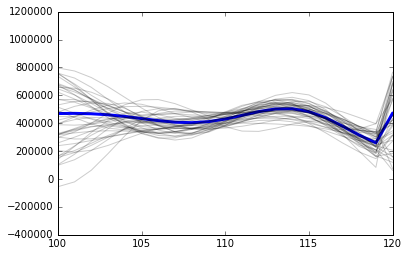

In [6]:
plt.plot(mu,lw=3)
plt.plot(fsamps[0:40,:].T,color='black',alpha=0.2);
plt.xlim([100,120])

NameError: name 'it' is not defined

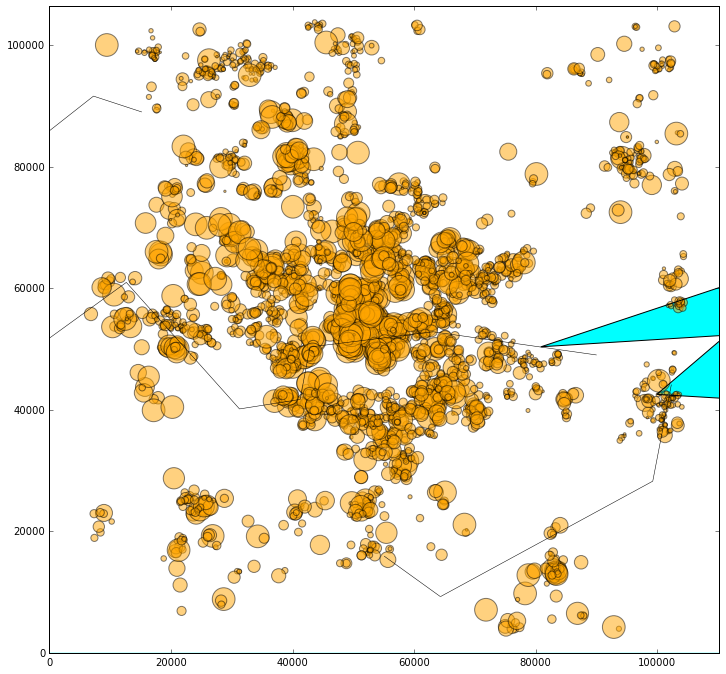

In [7]:
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap.pyproj as pyproj
import matplotlib.pyplot as plt
%matplotlib inline

osgb36=pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum
trainlats,trainlongs = osgb36(train[:,0],train[:,1],inverse=True)
testlats,testlongs = osgb36(tests[:,0],tests[:,1],inverse=True)


plt.figure(figsize=[12,12])
m = Basemap(llcrnrlon=-0.92,llcrnrlat=51.03,urcrnrlon=0.705,urcrnrlat=51.96,
        resolution='l',projection='tmerc',lon_0=-2,lat_0=49,suppress_ticks=False)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='white',lake_color='aqua',zorder=0)
m.drawrivers()
scale = 22000
m.scatter(trainlats,trainlongs,(y/scale)**2,latlon=True,marker='.',alpha=0.5, color='orange',edgecolors='black')
rgbacolours = np.zeros([len(mu),4])

#get number between 0 and 1 for amount of noise added
noise_scale = np.sqrt(np.diag(sampcov))
noise_scale = noise_scale - np.min(noise_scale)
noise_scale = noise_scale / np.max(noise_scale)
rgbacolours[:,3] = 1.0-(noise_scale*3.0)    
rgbacolours[rgbacolours[:,3]<0] = 0
#m.scatter(testlats,testlongs,(mu/scale)**2,latlon=True,marker='.',color=rgbacolours)
m.scatter(testlats,testlongs,(fsamps[it,:]/scale)**2,latlon=True,marker='.',color=rgbacolours)
plt.savefig('london_prices.pdf')

In [ ]:
data = datasets.load_fishlength()
train = data[:,1][:,None]
y = data[:,3][:,None]
y_norm, norm_mean, norm_std = dp4gp.transform(y)
tests = np.arange(0,160,1.0)[:,None]
lengthscales = 100.0
delta_Y = 4.0
delta_Ynorm = delta_Y/norm_std
sigma = 0.1
sigma_norm = sigma/norm_std
eps = 100.0
delta = 0.01

method = 'greedy_loop'
sampcov, K, Kstar = dp4gp.calc_DP_noise(train,tests,lengthscales,delta_Y,sigma,eps,delta,method,max_its = 1000, lr = 0.1)
samps_norm = np.random.multivariate_normal(np.zeros(len(tests)),sampcov,1000)

mu_norm = np.dot(Kstar,np.dot(np.linalg.inv(K),y_norm))

samps = samps_norm * norm_std
mu = dp4gp.untransform(mu_norm,norm_mean, norm_std)

#get our DP predictions
fsamps = np.repeat(mu.T,len(samps),0) + samps

print("Sample covariance in middle: %0.4f" % sampcov[15,15])

In [ ]:
plt.plot(train,y,'x',mew=3)
plt.plot(tests,mu,lw=3)
plt.ylim([0,6])
plt.plot(tests,fsamps[0:7,:].T,color='black',alpha=0.3);
